In [1]:
import torch
import argparse
import random
import math
from torch.utils import data
from torchvision import datasets, transforms

from J_Model import PCModel
import J_optim as optim
import J_utils as utils

from PIL import Image
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
from copy import copy
from time import perf_counter
from scipy.stats import ttest_ind, bootstrap
import seaborn as sns
import pandas as pd

from stimuli_data import *
from image_net_data import *
from output_embedding import *

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
default_font_size = 18
plt.rcParams.update({'font.size': default_font_size})

In [4]:
output_vec_dic = load_vector()

In [5]:
# ====================================================================================
#
# Global Parameters and Settings
#
# ====================================================================================
parser = argparse.ArgumentParser(description='Predictive Coding')

# dataset params
parser.add_argument('--batch-size', type=int, default=64,
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000,
                    help='input batch size for testing (default: 1000)')

# optim params
parser.add_argument('--lr', type=float, default=1e-4, help='learning rate')
parser.add_argument('--epoch', type=int, default=20, help='epochs for training') #12
parser.add_argument('--optim', type=str, default="Adam", help='optimization algorithm to use')
parser.add_argument('--beta-1', type=float, default=0.9, help='optimization algorithm to use')
parser.add_argument('--beta-2', type=float, default=0.99, help='optimization algorithm to use') #0.999

# inference params
parser.add_argument('--infer-lr', type=float, default=0.005, help='Inference learning rate')
parser.add_argument('--infer-iter', type=int, default=1500, help='Iteration for inference') #500
parser.add_argument('--test-iter', type=int, default=1500, help='Iteration for testing') #2000
parser.add_argument('--test-infer-iter', type=int, default=20000, help='Iteration for testing') #20000
parser.add_argument('--test-lr', type=int, default=0.005, help='Iteration for testing')

# convergence tolerance
parser.add_argument('--train-convergence-norm', type=str, default="Activity", help="Norm for measuring convergence")
parser.add_argument('--train-convergence-tolerance', type=float, default=1e-10, help="Tolerance for measuring convergence")
parser.add_argument('--test-convergence-norm', type=str, default="Activity", help="Norm for measuring convergence")
parser.add_argument('--test-convergence-tolerance', type=float, default=1, help="Tolerance for measuring convergence")
parser.add_argument('--output-vec-dic', type=float, default=None, help="Output vector embedding")

# experiment params
parser.add_argument('--seed', type=int, default=1, help='random seed (default: 1)')
parser.add_argument('--test-every', type=int, default=1, help='Test Cycle regards to Epoch ')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')

# args = parser.parse_args()
args, unknown = parser.parse_known_args()

# Gpu Setting
use_cuda = not args.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Misc. Setting
# torch.manual_seed(args.seed)
torch.manual_seed(random.randint(0,1024))


In [6]:
classes = ["n11939491", "n04330267", "n04326547", "n04328186", "n04330267", "n09468604", "n09472597", "n04522168", "n02974003",
           "n03220513", "n03223299", "n03240683", "n03355925", "n03930630", "n03837869", "n03773504", "n03530642", "n02701002", 
           "n02747177", "n02727426", "n02980441"]

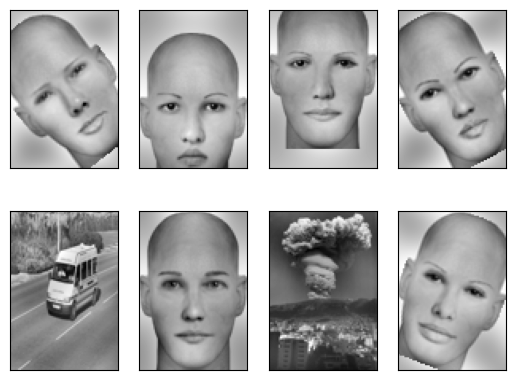

In [7]:
face_loader = get_dataloader(classes=classes, radius=(2, 3), batch_size=args.batch_size,
                            num_translations=3, num_rotations=3, num_images=123, augment_imagenet=False, output_vec_dic=args.output_vec_dic)
#face_loader = get_dataloader(classes=["n11939491"], radius=(2, 3), batch_size=args.batch_size,
#                            num_translations=0, num_rotations=0, num_images=123, augment_imagenet=False, output_vec_dic=args.output_vec_dic)

features, labels = next(iter(face_loader))

fig, axs = plt.subplots(2, 4)
i = 0
for ax in axs.flat:
    ax.imshow(features[i].squeeze(0), cmap="gray")
    #ax.set_title(labels[i].item())
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    i += 1

# Functions

In [19]:
def train_network(model, train_dl):
    optimizer = optim.get_optim(
        model.params,
        args.optim,
        args.lr,
        batch_scale=False,
        grad_clip=50,
        beta_1=args.beta_1,
        beta_2=args.beta_2)

    with torch.no_grad():
        metrics = {"acc": []}

        for epoch in range(1, args.epoch + 1):
            # Training
            #print(f"Epoch {epoch} is training with ({len(train_dl)} batches)")
            for batch_id, (img_batch, label_batch) in enumerate(train_dl):
                
                img_batch = utils.to_vector(img_batch)
                img_batch = img_batch.float().to(device)

                if args.output_vec_dic is not None:
                    label_batch = label_batch.double().to(device)
                else:
                    label_batch = label_batch.long()
                    label_batch = utils.one_hot(label_batch,n_classes=2).to(device)
    
                model.train_batch_supervised(img_batch, label_batch, args.infer_iter, fixed_preds=False)
    
                optimizer.step(
                    curr_epoch=epoch,
                    curr_batch=batch_id,
                    n_batches=len(train_dl),
                    batch_size=img_batch.size(0),
                )
    
            # Testing
            if epoch % args.test_every == 0:
                acc = 0
                for _, (img_batch, label_batch) in enumerate(train_dl):
                    img_batch = img_batch.double()
                    img_batch = utils.to_vector(img_batch).to(device)
                    
                    if args.output_vec_dic is not None:
                        label_batch = label_batch.double().to(device)
                    else:
                        label_batch = label_batch.long()
                        label_batch = utils.one_hot(label_batch,n_classes=2).to(device)
    
                    label_preds, t = model.test_batch_supervised(img_batch, label_batch, args.test_iter, fixed_preds=False, 
                                                                 tol=args.train_convergence_tolerance, norm=args.train_convergence_norm,
                                                                 output_vec_dic=args.output_vec_dic)
                    #print(t)
                    if args.output_vec_dic is None:
                        acc += utils.Want_accuracy(label_preds, label_batch)
                    else:
                        acc += utils.vector_accuracy(label_preds, label_batch, args.output_vec_dic)
                        
                metrics["acc"].append(acc / len(train_dl))
                print(f"\tTest epoch {epoch} with Accuracy: {acc / len(train_dl)}")

In [20]:
def test_network(model, test_dl, test_errors=False):
    conv_times = []
    #print(conv_times)
    acc = 0 
    with torch.no_grad():
        for _, (img_batch, label_batch) in enumerate(test_dl):
            img_batch = img_batch.double()
            img_batch = utils.to_vector(img_batch).to(device)
            
            if args.output_vec_dic is not None:
                label_batch = label_batch.double().to(device)
            else:
                label_batch = label_batch.long()
                label_batch = utils.one_hot(label_batch,n_classes=2).to(device)

            if test_errors:
                label_preds, times = model.test_batch_supervised_errors(img_batch, label_batch, args.test_infer_iter, fixed_preds=False, 
                                                             tol=args.test_convergence_tolerance, norm=args.test_convergence_norm, 
                                                             mu_dt=args.test_lr)
            else:
                label_preds, times = model.test_batch_supervised(img_batch, label_batch, args.test_infer_iter, fixed_preds=False, 
                                                             tol=args.test_convergence_tolerance, norm=args.test_convergence_norm, 
                                                             mu_dt=args.test_lr, output_vec_dic=args.output_vec_dic)
            
            for idx in range(len(times)):
                if (torch.argmax(label_preds[idx]).item() == torch.argmax(label_batch[idx]).item()) and (times[idx] is not None): #accurate & converged
                    conv_times.append(times[idx])
                elif False: #testing plotting
                    conv_times.append(np.random.random())

            if args.output_vec_dic is None:
                acc += utils.Want_accuracy(label_preds, label_batch)
            else:
                acc += utils.vector_accuracy(label_preds, label_batch, args.output_vec_dic)
    
    #print(sorted(conv_times))
    return conv_times, acc/len(test_dl)

In [10]:
def extract_outliers(series):
    #given a pd.Series, extract the indices of the outliers
    # outliers are points x such that:
    # x > Q3 + 1.5*IQR
    # x < Q1 - 1.5*IQR
    # IQR = Q3-Q1
    # Q1, 25th percentile
    # Q3, 75th percentile
    Q1 = series.quantile(q=0.25, interpolation='linear')
    Q3 = series.quantile(q=0.75, interpolation='linear')
    IQR = Q3 - Q1
    return series.index[(series > Q3 + 1.5*IQR) | (series < Q1 - 1.5*IQR)]

In [23]:
#test_model = PCModel(
#    nodes=[2, 100, 200, 300, 6800], #[2, 100, 300, 6800]
#    mu_dt=args.infer_lr,
#    act_fn=utils.Tanh())

In [24]:
#train_network(test_model, face_loader)

In [25]:
#temp, acc = test_network(test_model, face_loader)
#print(acc)

In [26]:
np.sum((output_vec_dic["Face Vector"] - output_vec_dic["Not Face Vector"])**2)

19.748468700423878

In [27]:
model = PCModel(
    nodes=[100, 200, 300, 400, 6800], #[2, 100, 300, 6800], #[2, 100, 200, 300, 6800]
    mu_dt=args.infer_lr,
    act_fn=utils.Tanh())

train_network(model, face_loader)

	Test epoch 1 with Accuracy: 0.36822916666666666
	Test epoch 2 with Accuracy: 0.3578125
	Test epoch 3 with Accuracy: 0.36171875
	Test epoch 4 with Accuracy: 0.35520833333333335
	Test epoch 5 with Accuracy: 0.35651041666666666
	Test epoch 6 with Accuracy: 0.3578125
	Test epoch 7 with Accuracy: 0.36171875
	Test epoch 8 with Accuracy: 0.35651041666666666
	Test epoch 9 with Accuracy: 0.36171875
	Test epoch 10 with Accuracy: 0.36171875
	Test epoch 11 with Accuracy: 0.36692708333333335
	Test epoch 12 with Accuracy: 0.35911458333333335
	Test epoch 13 with Accuracy: 0.35911458333333335
	Test epoch 14 with Accuracy: 0.3578125
	Test epoch 15 with Accuracy: 0.36432291666666666
	Test epoch 16 with Accuracy: 0.365625
	Test epoch 17 with Accuracy: 0.36041666666666666
	Test epoch 18 with Accuracy: 0.36041666666666666
	Test epoch 19 with Accuracy: 0.35651041666666666
	Test epoch 20 with Accuracy: 0.3578125


In [28]:
print(f"Epochs = {args.epoch}")
print(f"Weights learning rate = {args.lr}")
print(f"Optimization algorithm = {args.optim}")
print(f"Time step size = {args.infer_lr}")
print(f"Num iterations = {args.infer_iter}")

Epochs = 20
Weights learning rate = 0.0001
Optimization algorithm = Adam
Time step size = 0.005
Num iterations = 1500


In [29]:
acc = test_network(model, face_loader)[1]
print(f"Training accuracy = {round(acc, 3)}")

Training accuracy = 0.366


In [30]:
test_dl_single_sample = get_dataloader_features(feature=8, num_translations=0, num_rotations=0, batch_size=1, output_vec_dic=output_vec_dic)
test_dl_single_sample2 = get_dataloader_features(feature=5, num_translations=0, num_rotations=0, batch_size=1, output_vec_dic=output_vec_dic)

In [18]:
with torch.no_grad():
    img_batch, label_batch = next(iter(test_dl_single_sample))
    
    img_batch = img_batch.double()
    img_batch = utils.to_vector(img_batch).to(device)
    label_batch = label_batch.double().to(device)

    label_preds, times, phase_space = model.test_batch_supervised_phase_space(img_batch, label_batch, args.test_infer_iter, fixed_preds=False, 
                                                     tol=1, norm="Activities", 
                                                     mu_dt=0.05, error_dt=None, norm_errors=False, activities_index=0, 
                                                     output_vec_dic=output_vec_dic)
    pred = label_preds[0]
    actual = label_batch[0]
    print(pred)
    print(actual)

tensor([-0.6295,  0.3059, -1.0795,  0.3477,  1.9628,  0.6642, -2.9247,  0.5936,
        -1.2945,  0.6985,  0.2737, -0.6664,  2.1928, -0.3078,  1.3807, -2.0019,
         1.6160,  2.5294,  1.3213,  0.0396,  0.2414,  3.2801, -1.4450, -1.4982,
        -1.7412,  0.5399,  2.3262,  0.0353,  1.2290, -0.8655,  1.5623,  0.1935,
         1.4413, -0.3707,  1.6119,  2.2147,  2.2173,  1.1614,  0.2731,  1.5143,
         0.8497,  0.8487, -0.3424,  0.5664, -0.6936,  0.5809,  0.0900,  2.2974,
         1.3504, -1.3626, -0.2282, -0.1025,  1.6159, -1.2711,  2.2037, -1.0217,
        -0.8188, -0.6931, -0.7022,  1.1962,  0.0651,  0.5915,  0.6941, -0.1469,
         1.2481,  1.0939, -0.2706, -0.1263,  2.1418,  1.7847,  1.4547, -0.2982,
        -0.1028,  0.2691, -0.4877,  1.8916,  0.5873, -1.0945, -0.2776, -0.3303,
         0.9042,  1.0246,  0.7681,  0.1886,  0.9215,  0.7715, -0.5235,  0.1198,
        -1.3910,  0.4667,  0.4908, -0.4303,  0.0748, -2.5207,  0.4963,  0.1200,
         1.5657, -1.1759, -1.2618,  0.41

In [19]:
with torch.no_grad():
    print(np.sqrt(np.sum((pred.cpu().numpy() - output_vec_dic["Face Vector"])**2)))
    print(np.sqrt(np.sum((pred.cpu().numpy() - output_vec_dic["Not Face Vector"])**2)))
    print(actual.cpu() == torch.tensor(output_vec_dic["Face Vector"]).double())

11.859969258409247
12.45903897913709
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False])


In [20]:
np.sum(np.abs(output_vec_dic["Face Vector"] - actual.cpu().numpy()))

1.6921183295531567e-07

In [31]:
with torch.no_grad():
    img_batch, label_batch = next(iter(test_dl_single_sample))

    img_batch = img_batch.double()
    img_batch = utils.to_vector(img_batch).to(device)
    label_batch = label_batch.double().to(device)

    conv_times = []
    label_preds, times, phase_space = model.test_batch_supervised_phase_space(img_batch, label_batch, 5000, fixed_preds=False, 
                                                     tol=1, norm="Activities", 
                                                     mu_dt=0.005, error_dt=None, norm_errors=False, activities_index=0, 
                                                     output_vec_dic=output_vec_dic)
    for idx in range(len(times)):
        pred = label_preds[idx, :].to('cpu').numpy()
        actual = label_batch[idx, :].to('cpu').numpy()
        
        face_dist = np.sqrt(np.sum((pred - output_vec_dic["Face Vector"])**2))
        not_face_dist = np.sqrt(np.sum((pred - output_vec_dic["Not Face Vector"])**2))
        
        if (face_dist <= not_face_dist):
            if np.sum(np.abs(output_vec_dic["Face Vector"] - actual)) < 1:
                conv_times.append(times[idx])
        elif (face_dist > not_face_dist):
            if np.sum(np.abs(output_vec_dic["Not Face Vector"] - actual)) < 1:
                conv_times.append(times[idx])
    print(conv_times)
    
with torch.no_grad():
    img_batch, label_batch = next(iter(test_dl_single_sample2))
    
    img_batch = img_batch.double()
    img_batch = utils.to_vector(img_batch).to(device)
    label_batch = label_batch.double().to(device)
    
    conv_times = []
    label_preds, times, phase_space2 = model.test_batch_supervised_phase_space(img_batch, label_batch, 5000, fixed_preds=False, 
                                                     tol=1, norm="Activities", 
                                                     mu_dt=args.test_lr, error_dt=None, norm_errors=False, activities_index=0, 
                                                     output_vec_dic=output_vec_dic)
    for idx in range(len(times)):
        pred = label_preds[idx, :].to('cpu').numpy()
        actual = label_batch[idx, :].to('cpu').numpy()
        
        face_dist = np.sqrt(np.sum((pred - output_vec_dic["Face Vector"])**2))
        not_face_dist = np.sqrt(np.sum((pred - output_vec_dic["Not Face Vector"])**2))
        
        if (face_dist <= not_face_dist):
            if np.sum(np.abs(output_vec_dic["Face Vector"] - actual)) < 1:
                conv_times.append(times[idx])
        elif (face_dist > not_face_dist):
            if np.sum(np.abs(output_vec_dic["Not Face Vector"] - actual)) < 1:
                conv_times.append(times[idx])
    print(conv_times)

[None]
[None]


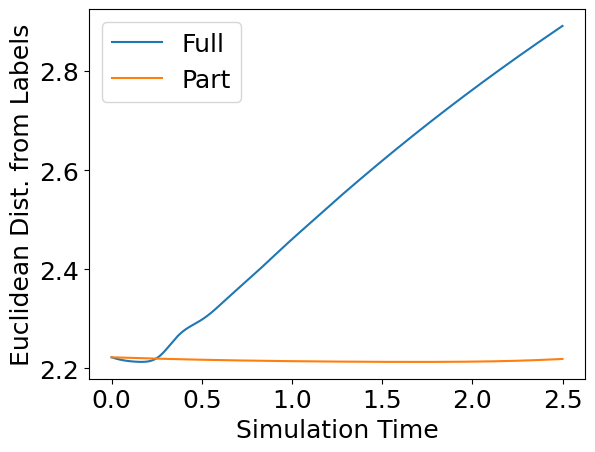

In [21]:
plt.figure()
plt.plot([args.test_lr*i for i in range(phase_space.shape[0])], phase_space, label="Full")
plt.plot([args.test_lr*i for i in range(phase_space2.shape[0])], phase_space2, label="Part")
plt.legend()
plt.xlabel("Simulation Time")
plt.ylabel("Euclidean Dist. from Labels")
plt.show()

# Training Population

In [11]:
population_size = 45
networks = [PCModel(
    nodes=[2, 100, 200, 300, 6800], #[2, 100, 300, 6800], #[2, 100, 200, 300, 6800]
    mu_dt=args.infer_lr,
    act_fn=utils.Tanh()) for i in range(population_size)]

In [16]:
#for model in networks:
#    for layer in model.layers:
#        layer.to(device)

In [ ]:
with open("training_networks_outputs.txt", "w") as file:
    file.write("") #overwrite current file
for idx, model in enumerate(networks):
    #print(f"Training the {idx+1}th network")
    
    t_start = perf_counter()
    train_network(model, face_loader)
    t_stop = perf_counter()

    with open("training_networks_outputs.txt", "a") as file: 
        file.write(f"Model {idx} done training in {round((t_stop-t_start)/60, 2)} minutes\n")
    #print("----------------------------------")
with open("training_networks_outputs.txt", "a") as file: 
    file.write("Done all training!")

In [ ]:
save_weights = False
if save_weights:
    for model_idx in range(len(networks)):
        for i in range(len(model.layers)):
            with open(f'Weights/model_{model_idx}_july_05_params_{i}.pickle', 'wb') as file:
                pickle.dump(networks[model_idx].layers[i].weights, file, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
load_models = True
if load_models:
    population_size = 45
    networks = [PCModel(
        nodes=[2, 100, 300, 6800], #[2, 100, 200, 300, 6800]
        mu_dt=args.infer_lr,
        act_fn=utils.Tanh()) for i in range(population_size)]
    for model_idx, model in enumerate(networks):
        for i in range(len(model.layers)):
            with open(f'Weights/model_{model_idx}_june_11_params_{i}.pickle', 'rb') as file:
                networks[model_idx].layers[i].weights = pickle.load(file)

# Testing Population

For each network in the population, we will test it on all the features, 

In [15]:
combination_to_feature_num_dict = {
    "1 Eye": "0 Feature",
    "2 Eyes": "1 Feature",
    "1 Eye, Nose": "1 Feature",
    "1 Eye, Mouth": "1 Feature",
    "2 Eyes, Nose": "2 Feature",
    "1 Eye, Nose, Mouth": "2 Feature",
    "2 Eyes, Mouth": "2 Feature",
    "Full Face": "3 Feature"
}

In [16]:
# set up dataframes, lists and dictionnaries to keep track of data
conv_times_for_features = {}


In [ ]:
with open("testing_networks_outputs.txt", "w") as file:
    file.write("") #overwrite current file

for feat_idx in list(range(1, 9)) + [17]: #iterate over all features
    with open("testing_networks_outputs.txt", "a") as file:
        file.write(f"Testing feature {feat_idx}:\n")
    #print(f"Testing feature {feat_idx}")
    test_dl = get_dataloader_features(feature=feat_idx, num_translations=0, num_rotations=0, 
                                      batch_size=args.batch_size, reflection=False)

    total_times = []
    for model_idx, model in enumerate(networks):
        t_start = perf_counter()
        conv_times, acc = test_network(model, test_dl)
        t_stop = perf_counter()
        
        total_times += conv_times
        
        #print(f"\tModel {model_idx} done")
        with open("testing_networks_outputs.txt", "a") as file:
            file.write(f"\tModel {model_idx} done testing in {round((t_stop-t_start)/60, 2)} minutes\n")
    conv_times_for_features[feat_idx] = total_times 
    #conv_times_for_features[combination_to_feature_num_dict[face_features_flip_dict[feat_idx]]] = total_times
with open("testing_networks_outputs.txt", "a") as file:
    file.write("Done all testing!")

## Feature Combinations

In [ ]:
print(f"Each feature should have {population_size*64} data points.")

In [ ]:
df_feature_combination = pd.DataFrame()
for key in conv_times_for_features.keys()-[1]:
    df_feature_combination = pd.concat([df_feature_combination,
                                       pd.DataFrame(np.array(conv_times_for_features[key]).T, columns=[face_features_flip_dict[key]])], 
                                       axis=1)
df_feature_combination = df_feature_combination.replace([np.inf, -np.inf], np.nan)
#pd.DataFrame(np.array([conv_times_for_features[key]['times'] for key in conv_times_for_features.keys()-[1]]).T, 
#                  columns=[face_features_flip_dict[key] for key in conv_times_for_features.keys()-[1]])

In [ ]:
df_feature_combination.to_csv("feature_combinations_july_05_no_reflections.csv")
#df_feature_combination = pd.read_csv("feature_combinations_june_14_no_reflections.csv", index_col=0)

In [ ]:
for col in df_feature_combination.columns:
    indices = extract_outliers(df_feature_combination[col])
    print(f"{col} has {len(indices)} outliers out of {len(df_feature_combination[col][~df_feature_combination[col].isna()])} data points")

In [ ]:
df_feature_combination.columns
temp_cols = ['1 Eye', '2 Eyes', '1 Eye, Nose', '1 Eye, Mouth', '2 Eyes, Nose',
       '1 Eye, Nose, Mouth', '2 Eyes, Mouth', 'Full Face']

In [ ]:
include_outliers = True

if include_outliers: #include everything
    df_subset = df_feature_combination[temp_cols]
else:
    df_subset = df_feature_combination[temp_cols].copy()
    for col in df_subset.columns:
        indices = extract_outliers(df_subset[col])
        df_subset[col][indices] = np.nan

fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(10, 6))

for i in range(len(df_subset.columns)):
    sns.histplot(df_subset, x=df_subset.columns[i], stat="density", ax=axes[i//4, i%4]).set(ylabel="")
    axes[i//4, i%4].set_title(df_subset.columns[i], fontsize=14, weight='bold')
    axes[i//4, i%4].set_xlabel("")
#axes[-1, 0].set_xlabel("Convergence Time", fontsize=default_font_size)
#axes[-1, 1].set_xlabel("Convergence Time", fontsize=default_font_size)
fig.supylabel("Density", x=0.02)
fig.supxlabel("Convergence Time")
plt.show()

#boxplot
fig, ax = plt.subplots()
sns.boxplot(df_feature_combination[temp_cols], orient="h", showfliers=include_outliers,
            showmeans=True,
            meanprops={'marker':'o',
                       'markerfacecolor':'white', 
                       'markeredgecolor':'black',
                       'markersize':'8'})
#ax.tick_params(axis='x', labelrotation=30)
#plt.title(f"{args.test_convergence_norm} Convergence", fontsize=14, weight="bold")
plt.xlabel("Convergence Time", fontsize=default_font_size)
plt.show()

In [ ]:
include_outliers = True

if include_outliers: #include everything
    df_subset = df_feature_combination
else:
    df_subset = df_feature_combination.copy()
    for col in df_subset.columns:
        indices = extract_outliers(df_subset[col])
        df_subset[col][indices] = np.nan

for col in df_subset.columns:
    t_result = ttest_ind(df_subset["Full Face"],
                        df_subset[col],
                        equal_var=False,
                        alternative="less",
                        nan_policy="omit")
    print(f"t-test for {col} against full face response time gives \n\t{t_result.pvalue}\n")

## Feature Number

In [ ]:
df_feature_num = pd.DataFrame()

df_feature_num["0 Feature"] = df_feature_combination["1 Eye"]

new_df = pd.DataFrame()
new_df["1 Feature"] = pd.concat([df_feature_combination["2 Eyes"], df_feature_combination["1 Eye, Nose"], df_feature_combination["1 Eye, Mouth"]], 
                                        ignore_index=True)
df_feature_num = pd.concat([df_feature_num, new_df], axis=1)

new_df = pd.DataFrame()
new_df["2 Feature"] = pd.concat([df_feature_combination["2 Eyes, Nose"], df_feature_combination["1 Eye, Nose, Mouth"], df_feature_combination["2 Eyes, Mouth"]], 
                                        ignore_index=True)
df_feature_num = pd.concat([df_feature_num, new_df], axis=1)

new_df = pd.DataFrame()
new_df["3 Feature"] = df_feature_combination["Full Face"]
df_feature_num = pd.concat([df_feature_num, new_df], axis=1)

df_feature_num = df_feature_num.replace([np.inf, -np.inf], np.nan)
"""
temp = list(conv_times_for_features.keys())
temp.sort()

conv_times_df = pd.DataFrame()
for key in temp:
    new_df = pd.DataFrame(np.array(conv_times_for_features[key]).T, columns=[key])
    conv_times_df = pd.concat([conv_times_df, new_df], axis=1)
"""

In [ ]:
df_feature_num.to_csv("feature_numbers_july_05_no_reflections.csv")
#df_feature_num = pd.read_csv("feature_numbers_june_14_no_reflections.csv", index_col=0)

In [ ]:
for col in df_feature_num.columns:
    indices = extract_outliers(df_feature_num[col])
    print(f"{col} has {len(indices)} outliers out of {len(df_feature_num[col][~df_feature_num[col].isna()])} data points")

In [ ]:
include_outliers = True

if include_outliers: #include everything
    df_subset = df_feature_num
else:
    df_subset = df_feature_num.copy()
    for col in df_subset.columns:
        indices = extract_outliers(df_subset[col])
        df_subset[col][indices] = np.nan

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 6))

sns.histplot(df_subset, x=df_subset.columns[0], stat="density", ax=axes[0, 0]).set(ylabel="")
axes[0, 0].set_title(df_subset.columns[0], fontsize=14, weight='bold')
axes[0, 0].set_xlabel("")
axes[0, 0].set_ylabel("")

sns.histplot(df_subset, x=df_subset.columns[1], stat="density", ax=axes[0, 1]).set(ylabel="")
axes[0, 1].set_title(df_subset.columns[1], fontsize=14, weight='bold')
axes[0, 1].set_xlabel("")
axes[0, 1].set_ylabel("")

sns.histplot(df_subset, x=df_subset.columns[2], stat="density", ax=axes[1, 0]).set(ylabel="")
axes[1, 0].set_title(df_subset.columns[2], fontsize=14, weight='bold')
axes[1, 0].set_xlabel("")
axes[0, 1].set_ylabel("")

sns.histplot(df_subset, x=df_subset.columns[3], stat="density", ax=axes[1, 1]).set(ylabel="")
axes[1, 1].set_title(df_subset.columns[3], fontsize=14, weight='bold')
axes[1, 1].set_xlabel("")
axes[0, 1].set_ylabel("")

#axes[-1, 0].set_xlabel("Convergence Time", fontsize=default_font_size)
#axes[-1, 1].set_xlabel("Convergence Time", fontsize=default_font_size)
#axes[0, 0].set_ylabel("Density", fontsize=default_font_size)
#axes[1, 0].set_ylabel("Density", fontsize=default_font_size)
fig.supylabel("Density")
fig.supxlabel("Convergence Time", y=-0.01)
plt.show()

#boxplot

fig, ax = plt.subplots()
sns.boxplot(df_feature_num, orient="h", showfliers=include_outliers,
            showmeans=True,
            meanprops={'marker':'o',
                       'markerfacecolor':'white', 
                       'markeredgecolor':'black',
                       'markersize':'8'})
#ax.tick_params(axis='x', labelrotation=30)
#plt.title(f"{args.test_convergence_norm} Convergence", fontsize=14, weight="bold")
plt.xlabel("Convergence Time", fontsize=default_font_size)
plt.show()

In [ ]:
include_outliers = True

if include_outliers: #include everything
    df_subset = df_feature_num
else:
    df_subset = df_feature_num.copy()
    for col in df_subset.columns:
        indices = extract_outliers(df_subset[col])
        df_subset[col][indices] = np.nan

fig, axes = plt.subplots(4, sharex=True, sharey=True, figsize=(6, 7))

sns.histplot(df_subset, x=df_subset.columns[0], stat="density", ax=axes[0]).set(ylabel="")
axes[0].set_title(df_subset.columns[0], fontsize=14, weight='bold')
axes[0].set_xlabel("")
axes[0].set_ylabel("")

sns.histplot(df_subset, x=df_subset.columns[1], stat="density", ax=axes[1]).set(ylabel="")
axes[1].set_title(df_subset.columns[1], fontsize=14, weight='bold')
axes[1].set_xlabel("")
axes[1].set_ylabel("")

sns.histplot(df_subset, x=df_subset.columns[2], stat="density", ax=axes[2]).set(ylabel="")
axes[2].set_title(df_subset.columns[2], fontsize=14, weight='bold')
axes[2].set_xlabel("")
axes[2].set_ylabel("")

sns.histplot(df_subset, x=df_subset.columns[3], stat="density", ax=axes[3]).set(ylabel="")
axes[3].set_title(df_subset.columns[3], fontsize=14, weight='bold')
axes[3].set_xlabel("")
axes[3].set_ylabel("")

#axes[-1, 0].set_xlabel("Convergence Time", fontsize=default_font_size)
#axes[-1, 1].set_xlabel("Convergence Time", fontsize=default_font_size)
#axes[0, 0].set_ylabel("Density", fontsize=default_font_size)
#axes[1, 0].set_ylabel("Density", fontsize=default_font_size)
fig.supylabel("Density", x=-0.05)
fig.supxlabel("Convergence Time", y=0.05)
plt.show()

#boxplot

fig, ax = plt.subplots()
sns.boxplot(df_feature_num, orient="h", showfliers=include_outliers,
            showmeans=True,
            meanprops={'marker':'o',
                       'markerfacecolor':'white', 
                       'markeredgecolor':'black',
                       'markersize':'8'})
#ax.tick_params(axis='x', labelrotation=30)
#plt.title(f"{args.test_convergence_norm} Convergence", fontsize=14, weight="bold")
plt.xlabel("Convergence Time", fontsize=default_font_size)
plt.show()

In [ ]:
include_outliers = True

if include_outliers: #include everything
    df_subset = df_feature_num
else:
    df_subset = df_feature_num.copy()
    for col in df_subset.columns:
        indices = extract_outliers(df_subset[col])
        df_subset[col][indices] = np.nan

for col in df_subset.columns:
    t_result = ttest_ind(df_subset["3 Feature"],
                        df_subset[col],
                        equal_var=False,
                        alternative="less",
                        nan_policy="omit")
    print(f"t-test for {col} against full face response time gives \n\t{t_result.pvalue}\n")

# Accuracies

In [21]:
val_loader = get_imagenet_validation_dataloader(classes=classes, num_images=10000, batch_size=64)

In [22]:
accuracies = []
with open("accuracy_val_outputs.txt", "w") as file:
    file.write("")
i = 0
for model in networks:
    times, acc = test_network(model, val_loader, test_errors=False)
    with open("accuracy_val_outputs.txt", "a") as file:
        file.write(f"Finished testing the {i} model\n")
    i += 1
    accuracies.append(acc)
with open("accuracy_val_outputs.txt", "a") as file:
    file.write(f"Final average accuracies {sum(accuracies)/len(accuracies)}\n")
    file.write(f"Accuracy list:\n{accuracies}")

In [23]:
accuracies= [0.5734375, 0.46354166666666663, 0.6244791666666667, 0.5911458333333333, 0.496875, 0.6067708333333333, 
             0.5401041666666666, 0.6088541666666667, 0.496875, 0.5302083333333334, 0.6244791666666667, 0.58125, 
             0.47916666666666663, 0.5833333333333333, 0.5635416666666666, 0.5401041666666666, 0.665625, 0.5734375, 
             0.45572916666666663, 0.5223958333333334, 0.48125, 0.565625, 0.496875, 0.6145833333333333, 0.5223958333333334, 
             0.5145833333333334, 0.5989583333333333, 0.6067708333333333, 0.565625, 0.6145833333333333, 0.5989583333333333, 
             0.4890625, 0.6578125, 0.496875, 0.58125, 0.5380208333333334, 0.5145833333333334, 0.5322916666666666, 
             0.5890625, 0.5067708333333334, 0.5401041666666666, 0.6223958333333333, 0.565625, 0.58125, 0.5302083333333334]
accuracies = np.array(accuracies)
print(np.mean(accuracies))
print(np.std(accuracies))

0.5565972222222222
0.05168994957770494


In [52]:
res = bootstrap((accuracies,), np.mean, confidence_level=0.99,
               n_resamples=9999, method='BCa')

In [53]:
res.confidence_interval

ConfidenceInterval(low=0.875714115804573, high=0.8824302823778465)

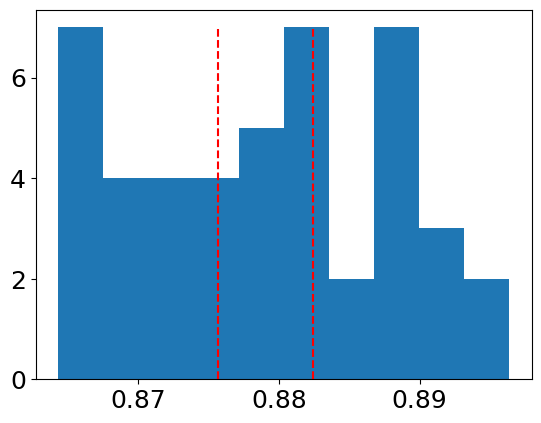

In [54]:
plt.figure()
plt.hist(accuracies)
plt.vlines([res.confidence_interval[0], res.confidence_interval[1]], 0, 7, color="r", ls="--")
plt.show()